In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data

In [2]:
# Set directories and file names 
dailyDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/'
#dailyDir   = '/glade/work/mdfowler/data/CESM2/'
middleName = '_day_CESM2_amip_r10i1p1f1_gn_'
varNames   = ['hfls','hfss','mrso','mrsos','tas','hurs','ps']

# Set time period portion of fileNames 
# timeName_flx  = ['19500101-19591231','19600101-19691231','19700101-19791231','19800101-19891231', 
#                  '19900101-19991231','20000101-20091231','20100101-20150101']
timeName_flx  = ['19700101-19791231','19800101-19891231', 
                 '19900101-19991231','20000101-20091231']

timeName_soil = ['19500101-19991231','20000101-20150101']


In [3]:
# Read in test file to get lat/lon 
fileName = dailyDir+varNames[0]+middleName+timeName_flx[0]+'.nc'
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 



/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'hfls' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
# Read in surface fluxes along

for iT in range(len(timeName_flx)):

    # --- Compile surface fluxes into singe large arrays in time 

    # Sensible heat flux
    shFile       = dailyDir+varNames[1]+middleName+timeName_flx[iT]+'.nc' # File name
    shDF         = xr.open_dataset(shFile,decode_times=True)
    shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


    if iT==0:
        shflx_full = shDF
    else: 
        shflx_full = xr.concat([shflx_full, shDF], dim="time")

    print('Done with ', timeName_flx[iT])



/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
<ipython-input-4-1f491abff45f>:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


Done with  19700101-19791231
Done with  19800101-19891231
Done with  19900101-19991231
Done with  20000101-20091231


In [7]:
# Read in soil moisture

for iT in range(len(timeName_soil)):

    # --- Compile soil moisture into singe large arrays in time 

#     # Full column SM 
#     soilFile = dailyDir+varNames[2]+middleName+timeName_soil[iT]+'.nc' # File name
#     soilDF   = xr.open_dataset(soilFile,decode_times=True) 
#     soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
    
    # 10 cm SM 
    soil10File = dailyDir+varNames[3]+middleName+timeName_soil[iT]+'.nc' # File name
    soil10DF   = xr.open_dataset(soil10File,decode_times=True)
    soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()
    
    if iT==0:
#         soilM_full   = soilDF 
        soilM10_full = soil10DF
    else: 
#         soilM_full   = xr.concat([soilM_full, soilDF], dim="time")
        soilM10_full = xr.concat([soilM10_full, soil10DF], dim="time")

    print('Done with ', timeName_soil[iT])


/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'mrsos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
<ipython-input-7-fdd1827c18d8>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soil10DF['time'] = soil10DF.indexes['time'].to_datetimeindex()


Done with  19500101-19991231
Done with  20000101-20150101


In [5]:
# Load pressure level of LCL (computed separately in Get_LCLpressure.py and saved as pickle file)
lclPath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_1970-2014.p'
#lclPath = '/glade/work/mdfowler/data/CESM2/LCL-pressure-HeightAboveGround_1970-2014.p'

Plcl    = pickle.load( open( lclPath, "rb" ) )


In [12]:
# Limit time period of soil moisture: 
dates       = pd.DatetimeIndex(soilM10_full['time'].values)
iIncludeSM  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
soilM10_sel = np.asarray(soilM10_full.mrsos.values)[iIncludeSM,:,:]

# Now limit the time period of everything else 
dates     = pd.DatetimeIndex(shflx_full['time'].values)
iInclude  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
dates     = dates[iInclude]

SHflx_sel = shflx_full.isel(time=iInclude)
Plcl_sel  = Plcl[iInclude,:,:]

In [10]:
# Convert soil moisture to volumetric (or at leas try...)
soilM10_convert = soilM10_sel / (1000.0*0.1)  # divide by density of water and by depth 


<ipython-input-37-7bb81a162d53>:4: RuntimeWarning: invalid value encountered in greater
  pctGT1 = (len(np.where(soilM10_convert>1)[0])/len(np.where(np.isfinite(soilM10_convert)==True)[0]))*100


Percent of values > 1.0: 0.09 percent


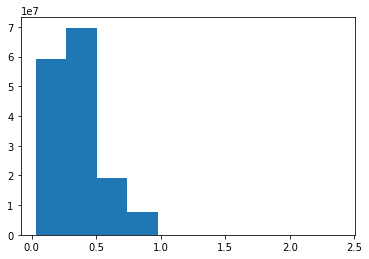

In [37]:
# Look at distribution of converted soil moisture. Most values should be between 0 and 1. 
plt.hist(soilM10_convert.reshape(len(lat)*len(lon)*np.shape(soilM10_convert)[0]))

pctGT1 = (len(np.where(soilM10_convert>1)[0])/len(np.where(np.isfinite(soilM10_convert)==True)[0]))*100
print('Percent of values > 1.0: %.2f percent' % pctGT1)

plt.show()


## Compute coupling index 

In [14]:
# Make one big xr.Dataset containing all the information we need  
dFull = SHflx_sel   # hfss 
dFull['mrsos'] = (('time','lat','lon'), soilM10_sel)
dFull['SMconvert'] = (('time','lat','lon'), soilM10_convert)
dFull['Plcl']  = (('time','lat','lon'), Plcl_sel)


In [15]:
dFull

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 10220)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2006-12-31
Dimensions without coordinates: nbnd
Data variables:
    hfss       (time, lat, lon) float32 -4.4452367 -4.4452367 ... -22.73284
    time_bnds  (time, nbnd) object 1978-12-31 00:00:00 ... 2006-12-31 00:00:00
    lat_bnds   (time, lat, nbnd) float64 -90.0 -89.53 -89.53 ... 89.53 90.0
    lon_bnds   (time, lon, nbnd) float64 -0.625 0.625 0.625 ... 358.1 359.4
    mrsos      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SMconvert  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    Plcl       (time, lat, lon) float64 6.456 6.456 6.456 6.456 ... nan nan nan
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                1587
    cesm_casename:          f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.010
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-11-21T11:58:13Z
    data_specs_version:     01.00.31
    experiment:             An atmosphere only climate simulation using presc...
    experiment_id:          amip
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.a...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     no parent
    parent_experiment_id:   no parent
    parent_mip_era:         no parent
    parent_source_id:       no parent
    parent_time_units:      no parent
    parent_variant_label:   no parent
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AGCM BGC AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    tracking_id:            hdl:21.14100/09a305e9-edf8-4118-b6db-b18d92417e5b
    variable_id:            hfss
    variant_info:           CMIP6 CESM2 AMIP hindcast (1950-2014) with intera...
    variant_label:          r10i1p1f1

In [16]:
# Compute CI 
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='mrsos',yname='hfss',averaging='season')

terra_coupling2 = cm.metrics.CouplingIndex()
terra_coupling2 = terra_coupling2.compute(dFull, xname='SMconvert',yname='hfss',averaging='season')



In [40]:
# Save out file that does this with volumetric soil moisture instead 
terra_coupling2.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_VolumetricSoilm_1979-2006_CESM2.nc')


## Look at differences in CI

In [17]:
diffCI = terra_coupling.mrsos_hfss_CI.values[1,:,:] - terra_coupling2.SMconvert_hfss_CI.values[1,:,:]
print('Mean difference in CI: %.3f' % np.nanmean(diffCI))

Mean difference in CI: 0.001


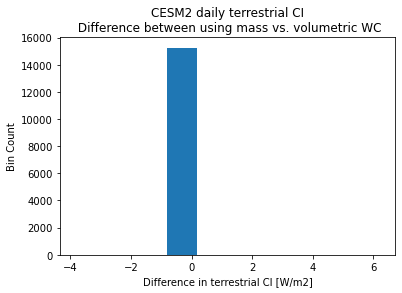

In [25]:
plt.hist(diffCI.reshape(len(lat)*len(lon)))
plt.title('CESM2 daily terrestrial CI\n Difference between using mass vs. volumetric WC')
plt.xlabel('Difference in terrestrial CI [W/m2]')
plt.ylabel('Bin Count')
plt.show()


In [18]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [19]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


In [20]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
TerraLeg_JJA_mass = np.squeeze(np.asarray(terra_coupling.mrsos_hfss_CI.values[1,:,:]))
TerraLeg_JJA_volm = np.squeeze(np.asarray(terra_coupling2.SMconvert_hfss_CI.values[1,:,:]))

# Make cyclic first 
TerraLeg_JJA_volm_cyclic, lon_cyclic  = cartopy.util.add_cyclic_point(TerraLeg_JJA_volm, lon)
TerraLeg_JJA_mass_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_mass, lon)

# Now get color coded arrays 
colorsTerraLeg_volm = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_mass = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1: volumetric water content ------

# Terra leg  
colorsTerraLeg_volm[np.where(TerraLeg_JJA_volm_cyclic<-20)]                                 = 1
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-20) & (TerraLeg_JJA_volm_cyclic<=-15))]  = 2
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-15) & (TerraLeg_JJA_volm_cyclic<=-10))]  = 3
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-10) & (TerraLeg_JJA_volm_cyclic<=-5))]   = 4
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-5) & (TerraLeg_JJA_volm_cyclic<=-2))]    = 5
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-2) & (TerraLeg_JJA_volm_cyclic<=-1))]    = 6
colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-1) & (TerraLeg_JJA_volm_cyclic<=0))]     = 7
colorsTerraLeg_volm[np.where(TerraLeg_JJA_volm_cyclic>0)]                                   = 8


# ----- CESM 1: mass water content ------

# Terra leg  
colorsTerraLeg_mass[np.where(TerraLeg_JJA_mass_cyclic<-20)]                                 = 1
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-20) & (TerraLeg_JJA_mass_cyclic<=-15))]  = 2
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-15) & (TerraLeg_JJA_mass_cyclic<=-10))]  = 3
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-10) & (TerraLeg_JJA_mass_cyclic<=-5))]   = 4
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-5) & (TerraLeg_JJA_mass_cyclic<=-2))]    = 5
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-2) & (TerraLeg_JJA_mass_cyclic<=-1))]    = 6
colorsTerraLeg_mass[np.where((TerraLeg_JJA_mass_cyclic>-1) & (TerraLeg_JJA_mass_cyclic<=0))]     = 7
colorsTerraLeg_mass[np.where(TerraLeg_JJA_mass_cyclic>0)]                                   = 8


<ipython-input-20-0eb02aa99a99>:18: RuntimeWarning: invalid value encountered in less
  colorsTerraLeg_volm[np.where(TerraLeg_JJA_volm_cyclic<-20)]                                 = 1
<ipython-input-20-0eb02aa99a99>:19: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-20) & (TerraLeg_JJA_volm_cyclic<=-15))]  = 2
<ipython-input-20-0eb02aa99a99>:19: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-20) & (TerraLeg_JJA_volm_cyclic<=-15))]  = 2
<ipython-input-20-0eb02aa99a99>:20: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-15) & (TerraLeg_JJA_volm_cyclic<=-10))]  = 3
<ipython-input-20-0eb02aa99a99>:20: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg_volm[np.where((TerraLeg_JJA_volm_cyclic>-15) & (TerraLeg_JJA_volm_cyclic<=-10))]  = 3
<ipython-input-20-0eb02aa99a99>:21: Runtim

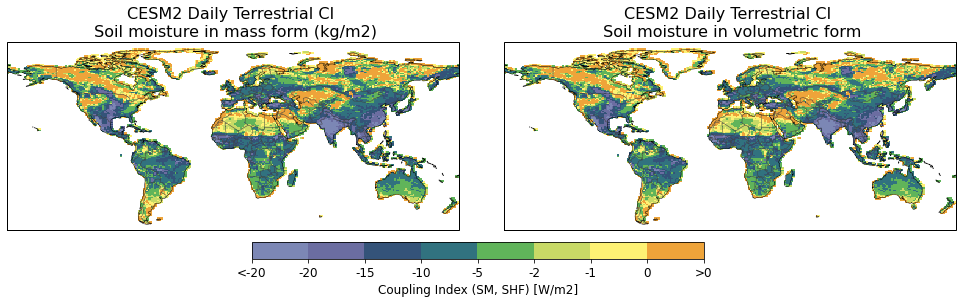

In [22]:

# Set up figure 
fig, axs = plt.subplots(1,2, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Zoom in on NH
# axs[0].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  
# axs[1].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  
# axs[2].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  

axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# ----- Plot mass soil moisture CI ------ 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_mass,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.2, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar

# Additional options 
axs[0].set_title('CESM2 Daily Terrestrial CI \n Soil moisture in mass form (kg/m2)',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot volumetric soil moisture CI ------ 
# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_volm,norm=norm, 
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

# Additional options 
axs[1].set_title('CESM2 Daily Terrestrial CI \n Soil moisture in volumetric form',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

